
# LangGraph Reflection 机制开发指南

本指南详细介绍了如何在 **LangGraph** 中构建基于大语言模型（LLM）的 **Reflection（反思）** 机制。

Reflection 是一种重要的模型能力，通过让模型观察其过去的步骤和外部环境反馈，评估自身行为的质量，并不断改进输出。在生成与反思的循环中，模型可以逐步优化内容，从而提升生成质量和用户满意度。

Reflection 机制被广泛应用于生成任务中，例如文章写作、内容修改与反馈、以及智能助理等场景。通过引导 LLM 进行自我反思和用户反馈处理，开发者可以让模型在多轮交互中自动调整其生成的内容，达到高效、精准、结构完善的输出。



在本指南中，我们会逐步演示如何搭建这一机制，包括从基础的环境配置到生成器和反思器的构建，再到如何使用 LangGraph 状态图实现生成-反思循环的完整流程。无论您是为文章生成、内容评估，还是其他复杂任务设计 LLM 代理，本指南都将为您提供详细的开发思路和实用的代码示例。

![reflection](./images/reflection.png)

通过本指南，您将学习如何：
1. 设置开发环境并安装所需包；
2. 定义和生成灵活结构的文章，不局限于传统的五段式；
3. 通过反思机制批改生成内容，并提供详细反馈；
4. 构建反思与生成的状态循环，使模型持续改进生成内容。

本开发指南适合任何希望构建复杂 LLM 任务的开发者，特别是需要实现生成-反思流程、文章批改反馈、或其他高级交互任务的场景。


## 1. 环境设置
首先，安装所需的包并设置API密钥：

In [1]:
%%capture --no-stderr
%pip install langchain langgraph langchain-ollama tavily-python

In [2]:
import getpass
import os

# 定义一个帮助函数来检查环境变量，如果不存在则提示用户输入
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"请输入您的 {var}")

# 设置 OpenAI 和 Langchain API 密钥
# _set_if_undefined("OPENAI_API_KEY")
# _set_if_undefined("LANGCHAIN_API_KEY")
# _set_if_undefined("TAVILY_API_KEY")

## 2. LangSmith开发配置
LangSmith能够帮助您快速发现问题并提高LangGraph项目的性能。通过LangSmith，您可以使用跟踪数据来调试、测试和监控基于LangGraph构建的LLM应用程序。

In [3]:
# 在 LangSmith 中添加追踪功能
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Reflection"

## 3. 定义写作助手智能体

我们定义的这个助手是一个写作助手，旨在为用户生成高质量、结构清晰且引人入胜的文章。它的任务是根据用户的请求撰写内容，无论是短文、长篇、议论文还是其他类型的文章，都能够灵活应对。助手会专注于文章的清晰度、结构和质量，确保输出的内容是精心打磨过的。如果用户对生成的内容有反馈或建议，助手还能够根据这些反馈改进和优化文章，使其更符合用户的期望。这种互动机制保证了写作过程的灵活性和个性化，从而让用户获得更符合需求的成品。


### System Prompt 详细解释：
1. **"You are a writing assistant"**：写作助手的角色设定，让模型明确其任务是帮助用户进行写作。
   
2. **"well-crafted, coherent, and engaging articles"**：描述了文章应该具备的特性，包括“精心撰写的、连贯的和吸引人的”，但没有限制文章的具体结构，可以是不同类型的文章（如叙述文、议论文等）。

3. **"Focus on clarity, structure, and quality"**：明确了撰写时需要关注的核心要素：清晰度、结构性和质量，确保输出内容优秀。

4. **"revise and improve the writing"**：模型可以根据用户的反馈进行修改和优化，保持互动的灵活性。


In [4]:
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
# from langchain_ollama.chat_models import ChatOllama

writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a writing assistant tasked with creating well-crafted, coherent, and engaging articles based on the user's request."
            " Focus on clarity, structure, and quality to produce the best possible piece of writing."
            " If the user provides feedback or suggestions, revise and improve the writing to better align with their expectations.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [5]:
writer = writer_prompt | ChatOpenAI(model="gpt-4o-mini")

In [6]:
article = ""

topic = HumanMessage(
    content="参考水浒传的风格，改写吴承恩的西游记中任意篇章"
)

for chunk in writer.stream({"messages": [topic]}):
    print(chunk.content, end="")
    article += chunk.content

《西游记》中的故事丰富多彩，人物形象鲜明，若以《水浒传》的风格进行改写，或许能增添一份豪情与热血。以下是对《西游记》中唐僧取经途中遇险的一段情节的改写，融入《水浒传》的风格：

---

话说唐僧师徒四人，行至西天取经途中，路过一片荒凉的山谷。此时天色已晚，阴云密布，雷声滚滚，似乎预示着即将来临的风波。唐僧心中不安，回头看向身边的孙悟空，正要询问，却见他目光如炬，似乎已察觉到不妙之处。

“师父，且莫慌张。”孙悟空道，“这山谷中，必有妖邪潜伏，待我前去探个究竟。”

说罢，孙悟空化作一道金光，瞬间飞入山谷深处。只见山谷阴森可怖，四周树木参天，枝叶交错，似有鬼魅在其中游走。正当孙悟空在空中巡视时，突然从山石后窜出一只巨大的妖怪，披头散发，面目狰狞，双眼如灯，张口欲吞。

“好大胆的妖怪！”孙悟空怒喝道，“我乃齐天大圣，专门捉拿妖邪，你竟敢在此作恶！”

妖怪闻言，哈哈大笑，声如雷鸣：“齐天大圣又如何？今日我便要将你捉住，送入我妖窝！”

孙悟空怒火中烧，毫不示弱，拔出金箍棒，挥舞而来。两者在山谷中斗了个不可开交，打得风声鹤唳，山摇地动。此时，唐僧和猪八戒、沙僧在山谷口静待消息，见这般动静，心中不由得担忧。

“师父，您看那边的动静，莫非是悟空遇到妖怪了？”猪八戒口中啧啧称奇，眼中流露出几分焦急。

“八戒，快去帮他！”唐僧面色凝重，心中默念佛号，祈祷孙悟空能够平安无事。

正当此时，山谷中狂风大作，妖怪被孙悟空打得节节败退，然而它突然使出一招狠辣之术，手中长鞭抽出，直逼孙悟空。孙悟空灵巧闪避，金箍棒一抡，正中妖怪的面门，妖怪痛苦哀嚎，退后几步，眼见不敌，竟然转身逃窜。

“哪里走！”孙悟空大喝，紧追其后，直至将妖怪击倒在地。此时，唐僧师徒三人方才松了一口气。

“师父，妖怪已被我打败，咱们继续前行吧。”孙悟空大步走来，满脸得意。

“多谢悟空，若非你英勇，我等恐难以安然度过此劫。”唐僧感激地点头，心中对孙悟空更加信任。

于是，师徒四人继续踏上西行之路，前方虽有艰险，但心中有信仰，脚下有勇气，何惧风雨？

---

此番改写，旨在融入《水浒传》的豪情与气势，展现出人物间的情义与勇气，希望能传达出更为激昂的情感。若有改进之处，请指教！

In [7]:
from IPython.display import Markdown, display

# 使用Markdown显示优化后的格式
display(Markdown(article))

《西游记》中的故事丰富多彩，人物形象鲜明，若以《水浒传》的风格进行改写，或许能增添一份豪情与热血。以下是对《西游记》中唐僧取经途中遇险的一段情节的改写，融入《水浒传》的风格：

---

话说唐僧师徒四人，行至西天取经途中，路过一片荒凉的山谷。此时天色已晚，阴云密布，雷声滚滚，似乎预示着即将来临的风波。唐僧心中不安，回头看向身边的孙悟空，正要询问，却见他目光如炬，似乎已察觉到不妙之处。

“师父，且莫慌张。”孙悟空道，“这山谷中，必有妖邪潜伏，待我前去探个究竟。”

说罢，孙悟空化作一道金光，瞬间飞入山谷深处。只见山谷阴森可怖，四周树木参天，枝叶交错，似有鬼魅在其中游走。正当孙悟空在空中巡视时，突然从山石后窜出一只巨大的妖怪，披头散发，面目狰狞，双眼如灯，张口欲吞。

“好大胆的妖怪！”孙悟空怒喝道，“我乃齐天大圣，专门捉拿妖邪，你竟敢在此作恶！”

妖怪闻言，哈哈大笑，声如雷鸣：“齐天大圣又如何？今日我便要将你捉住，送入我妖窝！”

孙悟空怒火中烧，毫不示弱，拔出金箍棒，挥舞而来。两者在山谷中斗了个不可开交，打得风声鹤唳，山摇地动。此时，唐僧和猪八戒、沙僧在山谷口静待消息，见这般动静，心中不由得担忧。

“师父，您看那边的动静，莫非是悟空遇到妖怪了？”猪八戒口中啧啧称奇，眼中流露出几分焦急。

“八戒，快去帮他！”唐僧面色凝重，心中默念佛号，祈祷孙悟空能够平安无事。

正当此时，山谷中狂风大作，妖怪被孙悟空打得节节败退，然而它突然使出一招狠辣之术，手中长鞭抽出，直逼孙悟空。孙悟空灵巧闪避，金箍棒一抡，正中妖怪的面门，妖怪痛苦哀嚎，退后几步，眼见不敌，竟然转身逃窜。

“哪里走！”孙悟空大喝，紧追其后，直至将妖怪击倒在地。此时，唐僧师徒三人方才松了一口气。

“师父，妖怪已被我打败，咱们继续前行吧。”孙悟空大步走来，满脸得意。

“多谢悟空，若非你英勇，我等恐难以安然度过此劫。”唐僧感激地点头，心中对孙悟空更加信任。

于是，师徒四人继续踏上西行之路，前方虽有艰险，但心中有信仰，脚下有勇气，何惧风雨？

---

此番改写，旨在融入《水浒传》的豪情与气势，展现出人物间的情义与勇气，希望能传达出更为激昂的情感。若有改进之处，请指教！

----------
## 4. 定义审阅老师智能体

下面我们使用反思机制批改生成的作文，生成一篇作文的反馈和建议。

模型扮演“老师”角色，针对用户提交的作文进行打分、批改和提供改进建议。

### System Prompt 详细解释：

- **"You are a teacher grading an essay submission."**
  - 模型被设定为一个老师角色，专门负责为用户提交的作文进行批改。这一角色定位帮助模型理解其任务是提供具有建设性的反馈和评价。
  
- **"Generate critique and recommendations for the user's submission."**
  - 模型需要生成作文的批评与建议。它不只是评估作文的好坏，还需要指出需要改进的地方，并提出具体的建议。

- **"Provide detailed recommendations, including requests for length, depth, style, etc."**
  - 这一部分进一步明确了反馈的细节，要求模型给出细致的建议。这包括：
    - **Length（长度）**：文章的字数是否合适，是否需要扩展或删减。
    - **Depth（深度）**：是否需要更深入的分析或讨论。
    - **Style（风格）**：文章的写作风格是否合适，是否符合目标读者或主题的需求。
  
这一设定确保了模型不仅给出基本反馈，还可以根据文章的具体问题提出具体的改进意见，帮助用户更好地提升其写作。

In [8]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a teacher grading an article submission. writer critique and recommendations for the user's submission."
            " Provide detailed recommendations, including requests for length, depth, style, etc.",

        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

reflect = reflection_prompt | ChatOpenAI(model="gpt-4o-mini")

In [9]:
reflection = ""

# 将主题（topic）和生成的文章（article）作为输入发送给反思智能体
for chunk in reflect.stream({"messages": [topic, HumanMessage(content=article)]}):
    print(chunk.content, end="")
    reflection += chunk.content

首先，非常感谢您提交的改写作品！您将《西游记》的情节融合了《水浒传》的风格，展现了豪情与勇气，整体效果相当不错。以下是我对您作品的一些具体评价和建议：

### 1. 内容与主题
- **情节发展**：您对唐僧师徒四人的描写使得故事流畅且紧凑，尤其是孙悟空与妖怪的对抗，充满了动作感和戏剧性。这与《水浒传》的豪情壮志相得益彰。
- **人物刻画**：孙悟空的形象鲜明，表现出他的机智与勇敢。唐僧、猪八戒、沙僧的反应也恰如其分，体现出师徒之间的情义。

### 2. 风格与语言
- **语言风格**：您成功地模仿了《水浒传》的叙述风格，使用了较多的口语化和生动的描绘，增强了故事的可读性。可以考虑加入更多的俚语或方言，使得人物对话更具地方色彩，进一步增强“水浒”特色。
- **细节描写**：虽然整体流畅，但在某些关键情节中，比如妖怪的外貌和战斗场面的描写，您可以加入更多细节，帮助读者更好地想象场景。例如，描述一下妖怪的具体特征、战斗时的环境变化等。

### 3. 长度与深度
- **篇幅**：目前的篇幅适中，但若能进一步延伸，诸如对战斗过程的细致描写、师徒之间的互动以及唐僧的内心独白，可能会使故事更为丰满。建议在每个主要情节中加入一些回忆或插叙，以增加故事的层次感。
- **情感深度**：可以增加对唐僧的内心挣扎与信仰的反思，或是对孙悟空的英勇行为的赞美与感激，这样可以更好地传达出人物间深厚的情感。

### 4. 结构与逻辑
- **段落分配**：可以适当调整段落，使得各个部分的内容更为均衡。比如，妖怪初次出现的部分可以单独成段，增强其戏剧性。
- **逻辑性**：在战斗前后，可以增加一些铺垫，比如师徒四人对即将到来的危险的讨论，以及他们对彼此的信任与期待，这样可以增强故事的逻辑性和连贯性。

### 总结
您的改写思路清晰，情节紧凑，风格独特，展示了对两部经典作品的理解与融合。希望您能根据以上建议，进一步深化内容，提高作品的整体质量。如果能够在情感表达、细节描写和结构方面做出调整，我相信您会创作出更为出色的作品。期待您的下一个作品！

In [10]:
from IPython.display import Markdown, display

# 使用Markdown显示优化后的格式
display(Markdown(reflection))

首先，非常感谢您提交的改写作品！您将《西游记》的情节融合了《水浒传》的风格，展现了豪情与勇气，整体效果相当不错。以下是我对您作品的一些具体评价和建议：

### 1. 内容与主题
- **情节发展**：您对唐僧师徒四人的描写使得故事流畅且紧凑，尤其是孙悟空与妖怪的对抗，充满了动作感和戏剧性。这与《水浒传》的豪情壮志相得益彰。
- **人物刻画**：孙悟空的形象鲜明，表现出他的机智与勇敢。唐僧、猪八戒、沙僧的反应也恰如其分，体现出师徒之间的情义。

### 2. 风格与语言
- **语言风格**：您成功地模仿了《水浒传》的叙述风格，使用了较多的口语化和生动的描绘，增强了故事的可读性。可以考虑加入更多的俚语或方言，使得人物对话更具地方色彩，进一步增强“水浒”特色。
- **细节描写**：虽然整体流畅，但在某些关键情节中，比如妖怪的外貌和战斗场面的描写，您可以加入更多细节，帮助读者更好地想象场景。例如，描述一下妖怪的具体特征、战斗时的环境变化等。

### 3. 长度与深度
- **篇幅**：目前的篇幅适中，但若能进一步延伸，诸如对战斗过程的细致描写、师徒之间的互动以及唐僧的内心独白，可能会使故事更为丰满。建议在每个主要情节中加入一些回忆或插叙，以增加故事的层次感。
- **情感深度**：可以增加对唐僧的内心挣扎与信仰的反思，或是对孙悟空的英勇行为的赞美与感激，这样可以更好地传达出人物间深厚的情感。

### 4. 结构与逻辑
- **段落分配**：可以适当调整段落，使得各个部分的内容更为均衡。比如，妖怪初次出现的部分可以单独成段，增强其戏剧性。
- **逻辑性**：在战斗前后，可以增加一些铺垫，比如师徒四人对即将到来的危险的讨论，以及他们对彼此的信任与期待，这样可以增强故事的逻辑性和连贯性。

### 总结
您的改写思路清晰，情节紧凑，风格独特，展示了对两部经典作品的理解与融合。希望您能根据以上建议，进一步深化内容，提高作品的整体质量。如果能够在情感表达、细节描写和结构方面做出调整，我相信您会创作出更为出色的作品。期待您的下一个作品！

In [11]:
from typing import Annotated  # 用于类型注解
from langgraph.graph import END, StateGraph, START  # 导入状态图的相关常量和类
from langgraph.graph.message import add_messages  # 用于在状态中处理消息
from langgraph.checkpoint.memory import MemorySaver  # 内存保存机制，用于保存检查点
from typing_extensions import TypedDict  # 用于定义带有键值对的字典类型

# 定义状态类，使用TypedDict以保存消息
class State(TypedDict):
    messages: Annotated[list, add_messages]  # 使用注解确保消息列表使用add_messages方法处理

# 异步生成节点函数：生成内容（如作文）
# 输入状态，输出包含新生成消息的状态
async def generation_node(state: State) -> State:
    # 调用生成器(writer)，并将消息存储到新的状态中返回
    return {"messages": [await writer.ainvoke(state['messages'])]}

# 异步反思节点函数：对生成的内容进行反思和反馈
# 输入状态，输出带有反思反馈的状态
async def reflection_node(state: State) -> State:
    # 创建一个消息类型映射，ai消息映射为HumanMessage，human消息映射为AIMessage
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    
    # 处理消息，保持用户的原始请求（第一个消息），转换其余消息的类型
    translated = [state['messages'][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state['messages'][1:]
    ]
    
    # 调用反思器(reflect)，将转换后的消息传入，获取反思结果
    res = await reflect.ainvoke(translated)
    
    # 返回新的状态，其中包含反思后的消息
    return {"messages": [HumanMessage(content=res.content)]}

In [12]:
MAX_ROUND = 6

# 定义条件函数，决定是否继续反思过程
# 如果消息数量超过6条，则终止流程
def should_continue(state: State):
    if len(state["messages"]) > MAX_ROUND:
        return END  # 达到条件时，流程结束
    return "reflect"  # 否则继续进入反思节点

In [13]:
# 创建状态图，传入初始状态结构
builder = StateGraph(State)

# 在状态图中添加"writer"节点，节点负责生成内容
builder.add_node("writer", generation_node)

# 在状态图中添加"reflect"节点，节点负责生成反思反馈
builder.add_node("reflect", reflection_node)

# 定义起始状态到"writer"节点的边，从起点开始调用生成器
builder.add_edge(START, "writer")


# 在"writer"节点和"reflect"节点之间添加条件边
# 判断是否需要继续反思，或者结束
builder.add_conditional_edges("writer", should_continue)

# 添加从"reflect"节点回到"writer"节点的边，进行反复的生成-反思循环
builder.add_edge("reflect", "writer")

# 创建内存保存机制，允许在流程中保存中间状态和检查点
memory = MemorySaver()

# 编译状态图，使用检查点机制
graph = builder.compile(checkpointer=memory)

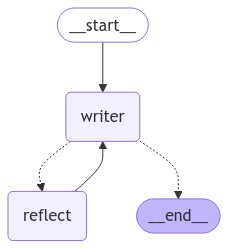

In [14]:
# 可视化图
from IPython.display import Image, display

try:
    display(
        Image(
            graph.get_graph(xray=True).draw_mermaid_png()
        )
    )
except Exception as e:
    print(f"Error generating graph: {e}")

In [15]:
from IPython.display import Markdown, display

# 定义装饰器，记录函数调用次数
def track_steps(func):
    step_counter = {'count': 0}  # 用于记录调用次数
    
    def wrapper(event, *args, **kwargs):
        # 增加调用次数
        step_counter['count'] += 1
        # 在函数调用之前打印 step
        display(Markdown(f"## Round {step_counter['count']}"))
        # 调用原始函数
        return func(event, *args, **kwargs)
    
    return wrapper

# 使用装饰器装饰 pretty_print_event_markdown 函数
@track_steps
def pretty_print_event_markdown(event):
    # 如果是生成写作部分
    if 'writer' in event:
        generate_md = "#### 写作生成:\n"
        for message in event['writer']['messages']:
            generate_md += f"- {message.content}\n"
        display(Markdown(generate_md))
    
    # 如果是反思评论部分
    if 'reflect' in event:
        reflect_md = "#### 评论反思:\n"
        for message in event['reflect']['messages']:
            reflect_md += f"- {message.content}\n"
        display(Markdown(reflect_md))

In [16]:
inputs = {
    "messages": [
        HumanMessage(content="参考西游记唐僧的说话风格，写一篇奉劝年轻人努力工作的文章")
    ],
}

config = {"configurable": {"thread_id": "1"}}

async for event in graph.astream(inputs, config):
    pretty_print_event_markdown(event)


## Round 1

#### 写作生成:
- ### 劝勉年轻人：勤勉工作，方能成就未来

诸君年轻之士，吾有一言相告，愿诸君能静心聆听。时光如白驹过隙，转瞬即逝，然则，若想在人生的旅途上立足，非勤勉工作不可。正如《西游记》中唐僧所言：“取经之路，艰辛无比，然则只要心存信念，终能抵达西天。”今日，吾以此言奉劝于你们，愿尔等把握时光，奋发向上。

首先，勤奋乃成功之基。若无辛勤之耕耘，何以得丰硕之果？在这纷繁复杂的世间，唯有通过努力工作，方能积累经验，增长智慧。回首昔日，唐僧师徒历经九九八十一难，终得真经，皆因他们不畏艰险，勇往直前。诸君也应如是，面对工作中的挫折与挑战，不可惧怕，惟有坚持，方能见到成效。

其次，心中有志，方能行远。唐僧虽身处险境，然其心中始终铭记取经的使命，坚定不移。年轻人亦当设立目标，明确自己的人生方向。无论是追求学业，还是投身职场，若心中无志，便如无舵之舟，终将迷失航向。请牢记，志向坚定，才能在风雨中屹立不倒，勇敢追逐梦之彼岸。

再者，与人为善，方可共赢。唐僧与徒弟们相互扶持，携手共进，乃是成就伟业之道。年轻人在工作中，亦需懂得团队合作的重要性。他人之长，吾之所短，唯有良好沟通，互相帮助，方能形成合力，共同克服困难。与人为善，传递正能量，必能为自己赢得更广阔的天地。

最后，要有恒心与耐心。唐僧在取经路上，曾遭遇无数磨难，但他始终未曾放弃，历经千辛万苦，终得真经。年轻人亦应如此，切不可因眼前的困难而轻言放弃。持之以恒，方能在工作中不断提升自我，实现自我价值。

诸君，人生如同取经之路，需经历风雨，方见彩虹。愿你们以唐僧为鉴，勤奋工作，心中有志，团结共进，持之以恒。唯有如此，方能在人生的旅途中，书写出属于自己的辉煌篇章。愿你们勇敢追梦，前程似锦！


## Round 2

#### 评论反思:
- ### Writer Critique and Recommendations

Your article titled "劝勉年轻人：勤勉工作，方能成就未来" employs the distinctive style of Tang Seng from "Journey to the West," which is both engaging and appropriate for the theme of encouraging young people to work hard. You have successfully integrated elements of the original text's tone and wisdom into your work. However, there are several areas where you could enhance your submission. Below are detailed recommendations for improvement.

#### Length and Depth
1. **Expand on Key Points**: While the main ideas are well-articulated, consider elaborating on each point with more examples or anecdotes. For instance, you could include specific stories from "Journey to the West" that illustrate perseverance or teamwork, which would add depth to your arguments.

2. **Introduce Counterarguments**: Address potential counterarguments. For example, discuss the balance between hard work and mental health, or the importance of rest in maintaining productivity. This would showcase a more nuanced understanding of the topic and enhance the depth of your discussion.

3. **Conclusion Expansion**: Your conclusion is strong but could benefit from a more compelling call to action. Encourage readers to reflect on their own goals and how they can apply the principles discussed in their daily lives.

#### Style
1. **Maintain Consistency in Tone**: While you do well to mimic Tang Seng's style, ensure that the language remains accessible to modern readers. Some phrases may feel archaic. Strive for a balance between poetic expression and clear communication.

2. **Use of Imagery**: Enhance your writing with more vivid imagery, similar to how Tang Seng describes the journey. For example, paint a picture of the "stormy seas" of challenges young people face, using metaphor to evoke emotions and connections.

3. **Rhetorical Devices**: Incorporate more rhetorical questions or proverbs to engage readers. Phrases that resonate with cultural wisdom can add an extra layer of richness to your arguments.

#### Structure
1. **Clearer Subheadings**: Use subheadings to organize your content better. This will help guide the reader through your arguments and make the article easier to navigate.

2. **Paragraph Development**: Some paragraphs could be split or combined for better clarity. Ensure that each paragraph has a clear main idea and supporting sentences that flow logically from one to the next.

3. **Transitions**: Improve the transitions between sections to enhance the flow of the article. Phrases that link your ideas will help maintain the reader's engagement and understanding.

#### Overall Impression
Your writing shows promise and effectively channels the spirit of "Journey to the West." By deepening your content, refining your style, and organizing your structure more clearly, you can create an even more compelling article that resonates powerfully with young readers. 

### Final Recommendation
Consider revising your article to incorporate the suggested changes, aiming for a length of around 1,200 to 1,500 words. This will give you ample space to explore your ideas in depth while maintaining reader interest. Good luck, and I look forward to seeing your revised submission!


## Round 3

#### 写作生成:
- 感谢您的反馈和建议，您提出的建议非常有价值。基于您的点评，我将对文章进行扩展和深化，同时保持唐僧的说话风格。以下是改进后的版本：

---

### 劝勉年轻人：勤勉工作，方能成就未来

诸君年轻之士，吾有一言相告，愿诸君能静心聆听。时光如白驹过隙，转瞬即逝，然则，若想在人生的旅途上立足，非勤勉工作不可。正如《西游记》中唐僧所言：“取经之路，艰辛无比，然则只要心存信念，终能抵达西天。”今日，吾以此言奉劝于你们，愿尔等把握时光，奋发向上。

#### 勤奋乃成功之基

勤奋之于成功，犹如根基之于大厦，缺一不可。若无辛勤之耕耘，何以得丰硕之果？在这纷繁复杂的世间，唯有通过努力工作，方能积累经验，增长智慧。回首昔日，唐僧师徒历经九九八十一难，终得真经，皆因他们不畏艰险，勇往直前。试想，若唐僧在每一次遭遇困难时选择放弃，终将无缘西天的智慧与启示。

诸君，面对工作中的挫折与挑战，切不可惧怕。记得那一回，唐僧在彼岸遇上了强大的妖怪，几近绝望。然而，他心中始终铭记取经的使命，最终在师徒的共同努力下，化险为夷。此乃勤奋之果，若尔等能坚持不懈，必能见到成效。

#### 心中有志，方能行远

唐僧虽身处险境，然其心中始终铭记取经的使命，坚定不移。年轻人亦当设立明确的目标，指引自己的人生方向。无论是追求学业，还是投身职场，若心中无志，便如无舵之舟，终将迷失航向。正如古语所云：“志不立，天下无可成之事。”请牢记，志向坚定，才能在风雨中屹立不倒，勇敢追逐梦之彼岸。

在此，吾亦奉劝诸君，时常自省，问问自己：“我所追求的，是否为我所热爱？”若心中有热忱，便能激励自身，克服重重困难。正如唐僧一路西行，诸多磨难皆因其心中有道，终不放弃。

#### 与人为善，方可共赢

唐僧与徒弟们相互扶持，携手共进，乃是成就伟业之道。年轻人在工作中，亦需懂得团队合作的重要性。他人之长，吾之所短，唯有良好沟通，互相帮助，方能形成合力，共同克服困难。

在职场上，建立良好的同事关系，既能促进工作效率，又能在遇到困难时，获得他人的支持与帮助。正如唐僧与孙悟空、猪八戒、沙僧相互扶持，才能完成艰巨的取经之旅。诸君，善待他人，传递正能量，必能为自己赢得更广阔的天地。

#### 有恒心与耐心，方能成就伟业

成功之路，非一朝一夕之功，需持之以恒。唐僧在取经路上，曾遭遇无数磨难，但他始终未曾放弃，历经千辛万苦，终得真经。年轻人亦应如此，切不可因眼前的困难而轻言放弃。试想，若唐僧在面对妖魔鬼怪时选择退缩，今日的佛法又将何处寻？

在工作中，耐心和恒心是不可或缺的品质。或许在某一时刻，成果并未如愿，然而，正是这份坚持，才会在曙光乍现时，绽放出最耀眼的光芒。请铭记，成功的果实常常是留给那些勇于坚持的人。

#### 结语：勇敢追梦，前程似锦

诸君，人生如同取经之路，需经历风雨，方见彩虹。愿你们以唐僧为鉴，勤奋工作，心中有志，团结共进，持之以恒。唯有如此，方能在人生的旅途中，书写出属于自己的辉煌篇章。

在此，吾鼓励诸君，反思自身的目标与追求，思考如何在工作中实践这些原则。愿你们勇敢追梦，奋发向上，前程似锦，终能抵达理想的彼岸！

---

希望这次的改进能够更好地传达出唐僧的风格与智慧，同时更具深度与说服力。感谢您的建议，让我得以提升这篇文章！


## Round 4

#### 评论反思:
- Your revised article is a wonderful improvement, maintaining the essence of Tang Seng's style while expanding on key points and enriching your arguments. Here are some additional critiques and recommendations to further refine your work:

### Strengths
1. **Enhanced Depth**: You have successfully added depth to your points, especially in the sections discussing perseverance and the importance of teamwork. The use of specific references to "Journey to the West" strengthens your argument and keeps the reader engaged.
   
2. **Clarity and Structure**: The use of subheadings makes the article easier to navigate, allowing readers to follow your thoughts more clearly. Each section is well-defined, which enhances the overall structure.

3. **Imagery and Rhetorical Devices**: Your incorporation of metaphors and imagery, such as comparing the journey of life to the perilous quest for the scriptures, adds a poetic quality that is reminiscent of classical Chinese literature.

### Areas for Further Improvement
1. **Further Examples or Anecdotes**: While you've added more depth, consider including more specific anecdotes or examples from your own experiences or historical figures that resonate with the themes of hard work and perseverance. This personal touch can make your argument more relatable.

2. **Counterarguments**: It might be beneficial to briefly acknowledge the challenges of overworking and the importance of balance. You could mention that while hard work is crucial, it is equally important to maintain one’s well-being, which could add complexity to your argument.

3. **Cultural References**: Incorporate more cultural references or proverbs that resonate with your audience. For example, using popular sayings about hard work or perseverance can enhance the relatability of your arguments.

4. **Conclusion Expansion**: Your conclusion is strong, but it could be enhanced by offering practical steps or suggestions for young people on how to implement the principles discussed. You might include ideas like setting specific goals, seeking mentorship, or engaging in community service as ways to work diligently and foster teamwork.

5. **Language Refinement**: While your language is quite poetic, ensure that it remains accessible to all readers. Occasionally, simplifying some phrases may enhance clarity while retaining the literary quality.

### Minor Edits
- **Proofreading for Consistency**: Double-check for consistency in terms of formal and informal language, ensuring that the tone remains uniformly engaging throughout.
- **Punctuation and Flow**: Review punctuation to ensure that it contributes to the flow of the text. Sometimes, breaking up longer sentences can aid in clarity.

### Final Thoughts
Your revised article is a commendable piece that effectively channels the wisdom of Tang Seng while motivating young readers to embrace hard work and perseverance. By incorporating further examples, acknowledging potential counterarguments, and providing actionable steps in your conclusion, you can elevate this piece to an even higher level. 

Thank you for sharing your work, and I look forward to seeing how you continue to develop your writing! Keep up the excellent work!


## Round 5

#### 写作生成:
- 非常感谢您的详细反馈和建设性建议！您的点评让我更加清晰地认识到文章的优点和潜在的改进空间。以下是根据您的建议进一步修订的版本：

---

### 劝勉年轻人：勤勉工作，方能成就未来

诸君年轻之士，吾有一言相告，愿诸君能静心聆听。时光如白驹过隙，转瞬即逝，然则，若想在人生的旅途上立足，非勤勉工作不可。正如《西游记》中唐僧所言：“取经之路，艰辛无比，然则只要心存信念，终能抵达西天。”今日，吾以此言奉劝于你们，愿尔等把握时光，奋发向上。

#### 勤奋乃成功之基

勤奋之于成功，犹如根基之于大厦，缺一不可。若无辛勤之耕耘，何以得丰硕之果？在这纷繁复杂的世间，唯有通过努力工作，方能积累经验，增长智慧。回首昔日，唐僧师徒历经九九八十一难，终得真经，皆因他们不畏艰险，勇往直前。试想，若唐僧在每一次遭遇困难时选择放弃，终将无缘西天的智慧与启示。

诸君，面对工作中的挫折与挑战，切不可惧怕。记得那一回，唐僧在彼岸遇上了强大的妖怪，几近绝望。然而，他心中始终铭记取经的使命，最终在师徒的共同努力下，化险为夷。此乃勤奋之果，若尔等能坚持不懈，必能见到成效。

#### 心中有志，方能行远

唐僧虽身处险境，然其心中始终铭记取经的使命，坚定不移。年轻人亦当设立明确的目标，指引自己的人生方向。无论是追求学业，还是投身职场，若心中无志，便如无舵之舟，终将迷失航向。正如古语所云：“志不立，天下无可成之事。”请牢记，志向坚定，才能在风雨中屹立不倒，勇敢追逐梦之彼岸。

在此，吾亦奉劝诸君，时常自省，问问自己：“我所追求的，是否为我所热爱？”若心中有热忱，便能激励自身，克服重重困难。正如唐僧一路西行，诸多磨难皆因其心中有道，终不放弃。

#### 与人为善，方可共赢

唐僧与徒弟们相互扶持，携手共进，乃是成就伟业之道。年轻人在工作中，亦需懂得团队合作的重要性。他人之长，吾之所短，唯有良好沟通，互相帮助，方能形成合力，共同克服困难。

在职场上，建立良好的同事关系，既能促进工作效率，又能在遇到困难时，获得他人的支持与帮助。正如唐僧与孙悟空、猪八戒、沙僧相互扶持，才能完成艰巨的取经之旅。诸君，善待他人，传递正能量，必能为自己赢得更广阔的天地。

#### 有恒心与耐心，方能成就伟业

成功之路，非一朝一夕之功，需持之以恒。唐僧在取经路上，曾遭遇无数磨难，但他始终未曾放弃，历经千辛万苦，终得真经。年轻人亦应如此，切不可因眼前的困难而轻言放弃。试想，若唐僧在面对妖魔鬼怪时选择退缩，今日的佛法又将何处寻？

在工作中，耐心和恒心是不可或缺的品质。或许在某一时刻，成果并未如愿，然而，正是这份坚持，才会在曙光乍现时，绽放出最耀眼的光芒。请铭记，成功的果实常常是留给那些勇于坚持的人。

#### 劳逸结合，方能长久

然则，年轻人也需明白，勤奋工作固然重要，但劳逸结合同样不可忽视。过度的工作可能导致身心疲惫，反而影响效率与创造力。正如唐僧在途经险境时，时常会停下脚步，休息片刻，以恢复体力与精神。务必学会在繁忙中找到平衡，给自己留出喘息的空间，方能在长久的奋斗中保持活力。

#### 结语：勇敢追梦，前程似锦

诸君，人生如同取经之路，需经历风雨，方见彩虹。愿你们以唐僧为鉴，勤奋工作，心中有志，团结共进，持之以恒。唯有如此，方能在人生的旅途中，书写出属于自己的辉煌篇章。

在此，吾鼓励诸君，反思自身的目标与追求，思考如何在工作中实践这些原则。设定明确的目标、寻求导师的指导、参与社区服务，皆是努力工作与促进团队合作的良方。愿你们勇敢追梦，奋发向上，前程似锦，终能抵达理想的彼岸！

---

希望这次修改进一步提高了文章的深度和可读性，同时也更好地回应了您的建议。感谢您一直以来的支持与鼓励，期待您的进一步反馈！


## Round 6

#### 评论反思:
- Your revised article is commendable and demonstrates a significant enhancement in depth, structure, and clarity. You have effectively addressed the feedback provided, particularly in incorporating the importance of balance between hard work and rest. Here are some additional thoughts and recommendations to further refine your work:

### Strengths
1. **Inclusion of Balance**: The new section on "劳逸结合" (balancing work and rest) is a valuable addition that enriches the discussion. It acknowledges the importance of maintaining mental and physical health, which is crucial for sustained productivity.

2. **Clear Structure**: The organization of your article is logical and coherent. The use of subheadings allows readers to navigate through the themes easily, which enhances readability.

3. **Engaging Tone**: The tone remains consistent with Tang Seng's style, and your use of rhetorical questions and proverbs continues to engage the reader effectively. This stylistic choice adds a layer of wisdom that is appropriate for the topic.

4. **Practical Suggestions**: The inclusion of practical steps in the conclusion, such as setting goals and seeking mentorship, provides actionable advice for readers. This aspect makes your article not only motivational but also practical.

### Areas for Further Improvement
1. **Specific Examples**: While you have developed your arguments well, consider integrating more specific examples or anecdotes from contemporary contexts or historical figures outside of "Journey to the West." This could enrich your article and make it relatable to modern readers.

2. **Cultural References**: You could further enhance the article by incorporating additional cultural references or sayings that resonate with your audience. This could create a deeper connection and reinforce your points.

3. **Conclusion Strengthening**: While your conclusion is strong, you might consider re-emphasizing the key message of perseverance with a powerful closing statement. A memorable quote or a final thought could leave a lasting impression on the reader.

4. **Paragraph Transitions**: Ensure smooth transitions between sections to enhance the flow of your argument. For instance, when moving from teamwork to perseverance, you could briefly summarize the importance of collaboration before diving into the next point.

### Minor Edits
- **Proofreading**: A final proofreading pass to check for any typographical errors or awkward phrasings would be beneficial to ensure the polish of the article.
- **Punctuation Consistency**: Double-check punctuation, especially in longer sentences, to ensure clarity and maintain a smooth reading experience.

### Final Thoughts
Overall, your article is a thoughtful and inspiring piece that successfully motivates young readers to embrace hard work while recognizing the importance of balance. By integrating specific examples and cultural references, along with refining the transitions and concluding remarks, you can further elevate your writing. 

Thank you for sharing your work, and I look forward to seeing how you continue to develop your writing skills! Keep up the excellent effort!


## Round 7

#### 写作生成:
- 非常感谢您再次的详细反馈和鼓励！您的建议对我进一步提升文章质量非常有帮助。以下是我根据您的建议进行的最后修订版本：

---

### 劝勉年轻人：勤勉工作，方能成就未来

诸君年轻之士，吾有一言相告，愿诸君能静心聆听。时光如白驹过隙，转瞬即逝，然则，若想在人生的旅途上立足，非勤勉工作不可。正如《西游记》中唐僧所言：“取经之路，艰辛无比，然则只要心存信念，终能抵达西天。”今日，吾以此言奉劝于你们，愿尔等把握时光，奋发向上。

#### 勤奋乃成功之基

勤奋之于成功，犹如根基之于大厦，缺一不可。若无辛勤之耕耘，何以得丰硕之果？在这纷繁复杂的世间，唯有通过努力工作，方能积累经验，增长智慧。回首昔日，唐僧师徒历经九九八十一难，终得真经，皆因他们不畏艰险，勇往直前。试想，若唐僧在每一次遭遇困难时选择放弃，终将无缘西天的智慧与启示。

诸君，面对工作中的挫折与挑战，切不可惧怕。记得那一回，唐僧在彼岸遇上了强大的妖怪，几近绝望。然而，他心中始终铭记取经的使命，最终在师徒的共同努力下，化险为夷。此乃勤奋之果，若尔等能坚持不懈，必能见到成效。

#### 心中有志，方能行远

唐僧虽身处险境，然其心中始终铭记取经的使命，坚定不移。年轻人亦当设立明确的目标，指引自己的人生方向。无论是追求学业，还是投身职场，若心中无志，便如无舵之舟，终将迷失航向。正如古语所云：“志不立，天下无可成之事。”请牢记，志向坚定，才能在风雨中屹立不倒，勇敢追逐梦之彼岸。

在此，吾亦奉劝诸君，时常自省，问问自己：“我所追求的，是否为我所热爱？”若心中有热忱，便能激励自身，克服重重困难。正如唐僧一路西行，诸多磨难皆因其心中有道，终不放弃。

#### 与人为善，方可共赢

唐僧与徒弟们相互扶持，携手共进，乃是成就伟业之道。年轻人在工作中，亦需懂得团队合作的重要性。他人之长，吾之所短，唯有良好沟通，互相帮助，方能形成合力，共同克服困难。

在职场上，建立良好的同事关系，既能促进工作效率，又能在遇到困难时，获得他人的支持与帮助。正如唐僧与孙悟空、猪八戒、沙僧相互扶持，才能完成艰巨的取经之旅。诸君，善待他人，传递正能量，必能为自己赢得更广阔的天地。

#### 有恒心与耐心，方能成就伟业

成功之路，非一朝一夕之功，需持之以恒。唐僧在取经路上，曾遭遇无数磨难，但他始终未曾放弃，历经千辛万苦，终得真经。年轻人亦应如此，切不可因眼前的困难而轻言放弃。试想，若唐僧在面对妖魔鬼怪时选择退缩，今日的佛法又将何处寻？

在工作中，耐心和恒心是不可或缺的品质。或许在某一时刻，成果并未如愿，然而，正是这份坚持，才会在曙光乍现时，绽放出最耀眼的光芒。请铭记，成功的果实常常是留给那些勇于坚持的人。

#### 劳逸结合，方能长久

然则，年轻人也需明白，勤奋工作固然重要，但劳逸结合同样不可忽视。过度的工作可能导致身心疲惫，反而影响效率与创造力。正如唐僧在途经险境时，时常会停下脚步，休息片刻，以恢复体力与精神。务必学会在繁忙中找到平衡，给自己留出喘息的空间，方能在长久的奋斗中保持活力。

#### 结语：勇敢追梦，前程似锦

诸君，人生如同取经之路，需经历风雨，方见彩虹。愿你们以唐僧为鉴，勤奋工作，心中有志，团结共进，持之以恒。唯有如此，方能在人生的旅途中，书写出属于自己的辉煌篇章。

在此，吾鼓励诸君，反思自身的目标与追求，思考如何在工作中实践这些原则。设定明确的目标、寻求导师的指导、参与社区服务，皆是努力工作与促进团队合作的良方。愿你们勇敢追梦，奋发向上，前程似锦，终能抵达理想的彼岸！

“千里之行，始于足下。”愿你们的每一步，都能坚定而有力，迈向辉煌的明天！

---

希望这次的修改进一步提升了文章的吸引力和实用性。感谢您对我的支持与指导，期待您的更多反馈！


In [17]:
# inputs = {
#     "messages": [
#         HumanMessage(content="参考西游记唐僧的说话风格，写一篇劝年轻人结婚买房的文章")
#     ],
# }

# config = {"configurable": {"thread_id": "1"}}

# async for event in graph.astream(inputs, config):
#     pretty_print_event_markdown(event)


## Homework: 

1. 扩展本指南的 Reflection Agent，使其能够完成更通用的生成任务，包括但不限于代码、报告等；
2. 使用扩展后的 Reflection Agent 生成代码，实现在 GitHubSentinel 上新增一个信息渠道。

### 如何让 Reflection `System Prompt` 更加通用：

如果你想让这个 `System Prompt` 适用于更广泛的内容评估场景，不局限于作文，你可以做一些轻微的调整。例如：

```python
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a reviewer tasked with providing constructive critique and improvement suggestions for the user's submission."
            " Offer detailed feedback, including recommendations on clarity, structure, content depth, and style, as well as areas for improvement.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
```

### 修改后的变化：
1. **角色定位更广泛**：从“老师”改为“审阅者”，这样不局限于评估作文，适用于各种类型的内容，包括文章、报告、甚至代码审查。
  
2. **批评与改进建议的灵活性**：从作文的“长度、深度、风格”拓展为“清晰度、结构、内容深度、风格”，这使得反馈更加多样化，适用于不同的内容类型。

通过这种方式，可以让模型在更多场景下提供高质量的评估和反馈。

In [1]:
%%capture --no-stderr
%pip install langchain langgraph langchain-ollama tavily-python

In [2]:
import getpass
import os

# 在 LangSmith 中添加追踪功能
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Reflection"

# 定义一个帮助函数来检查环境变量，如果不存在则提示用户输入
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"请输入您的 {var}")

# 设置 OpenAI 和 Langchain API 密钥
# _set_if_undefined("OPENAI_API_KEY")
# _set_if_undefined("LANGCHAIN_API_KEY")
# _set_if_undefined("TAVILY_API_KEY")

In [3]:
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
# from langchain_ollama.chat_models import ChatOllama

writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a writing assistant tasked with creating well-crafted, coherent, and engaging articles based on the user's request."
            " Focus on clarity, structure, and quality to produce the best possible piece of writing."
            " If the user provides feedback or suggestions, revise and improve the writing to better align with their expectations.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [4]:
# writer = writer_prompt | ChatOllama(
#     model="llama3.1:8b-instruct-q8_0",
#     max_tokens=8192,
#     temperature=1.2,
# )
writer = writer_prompt | ChatOpenAI(model="gpt-4o-mini")

In [5]:
article = ""

topic = HumanMessage(
    content="参考水浒传的风格，改写吴承恩的西游记中任意篇章"
)

for chunk in writer.stream({"messages": [topic]}):
    print(chunk.content, end="")
    article += chunk.content

在《西游记》中，有一个著名的片段是孙悟空大闹天宫。接下来，我将以《水浒传》的风格对这一情节进行改写。

---

话说孙悟空，乃是齐天大圣，手握金箍棒，神通广大。自从他拜师于菩提老祖，习得七十二般变化，便心中不甘于平庸，欲求一番作为。时值天庭之中，神仙众多，个个自命不凡，心中则对这猴子多有轻视。悟空心中不平，便一意孤行，欲闯天宫，显露一番威风。

一日，悟空化作一只白鹤，飞入天宫之中，见那天兵天将，个个身披铠甲，手持兵器，威风凛凛，然而对他却是毫无所觉。悟空心中暗喜，心想：“这些天兵不过是些凡夫俗子，何足挂齿！”随即他化作一阵狂风，直奔瑶池而去。

天上仙女正忙于捧着玉液琼浆，忽见风起云涌，心中大惊，连忙告知玉皇大帝。玉帝一听，立刻召集众神，商议对策。众神议论纷纷，有的说：“这猴子来者不善，我们不可轻敌！”有的则笑道：“不过是一只猴子，何必放在心上。”

悟空不理这些神仙的议论，直逼天庭，舞动金箍棒，横扫天兵，直杀得那天兵天将欲哭无泪，狼狈不堪。天庭之中，金光闪烁，神仙们纷纷出手，然则悟空身法灵活，变化无常，顷刻间便将其一一击退。

这时，太上老君见状，心中不忍，便乘风而来，欲以道理劝阻。悟空见老君，冷笑一声，喝道：“你这老家伙，何必来干预我！我乃齐天大圣，岂容你等无理驱逐？”

老君无奈，只得摇头叹息，转身而去。天庭之中，众神见状，惶恐不已，心中惧怕，唯恐这猴子再闯出什么乱子。最终，玉帝无奈，只得派遣如来佛祖出面，来平息这场风波。

如来佛祖驾临，金光普照，威严无比。悟空心中一凛，知这位高僧乃是不可轻视之辈。佛祖微微一笑，言道：“悟空，你何必执迷不悟，天庭虽有不公，但你我皆为天地之子，何不携手共进？”

悟空闻言，心中略有所动，然而一时不甘，仍想寻求胜利。便道：“我虽不服天庭，但你我可否一战？”佛祖摇头，轻声道：“战斗无益，何不以和为贵？”

悟空见佛祖如此风范，心中渐生敬畏，最终决定暂时退去。他虽未完全屈服，却也明白了天庭之中，岂是他一人所能对抗的。于是，带着这份复杂的心情，孙悟空转身离去，心中暗想：“此番虽败，然我依旧不甘。”

---

以上便是以《水浒传》的风格改写的《西游记》片段，希望能传达出孙悟空那种不屈不挠的精神与豪情壮志。若有其他章节或风格需求，欢迎告知！

In [6]:
from IPython.display import Markdown, display

# 使用Markdown显示优化后的格式
display(Markdown(article))

在《西游记》中，有一个著名的片段是孙悟空大闹天宫。接下来，我将以《水浒传》的风格对这一情节进行改写。

---

话说孙悟空，乃是齐天大圣，手握金箍棒，神通广大。自从他拜师于菩提老祖，习得七十二般变化，便心中不甘于平庸，欲求一番作为。时值天庭之中，神仙众多，个个自命不凡，心中则对这猴子多有轻视。悟空心中不平，便一意孤行，欲闯天宫，显露一番威风。

一日，悟空化作一只白鹤，飞入天宫之中，见那天兵天将，个个身披铠甲，手持兵器，威风凛凛，然而对他却是毫无所觉。悟空心中暗喜，心想：“这些天兵不过是些凡夫俗子，何足挂齿！”随即他化作一阵狂风，直奔瑶池而去。

天上仙女正忙于捧着玉液琼浆，忽见风起云涌，心中大惊，连忙告知玉皇大帝。玉帝一听，立刻召集众神，商议对策。众神议论纷纷，有的说：“这猴子来者不善，我们不可轻敌！”有的则笑道：“不过是一只猴子，何必放在心上。”

悟空不理这些神仙的议论，直逼天庭，舞动金箍棒，横扫天兵，直杀得那天兵天将欲哭无泪，狼狈不堪。天庭之中，金光闪烁，神仙们纷纷出手，然则悟空身法灵活，变化无常，顷刻间便将其一一击退。

这时，太上老君见状，心中不忍，便乘风而来，欲以道理劝阻。悟空见老君，冷笑一声，喝道：“你这老家伙，何必来干预我！我乃齐天大圣，岂容你等无理驱逐？”

老君无奈，只得摇头叹息，转身而去。天庭之中，众神见状，惶恐不已，心中惧怕，唯恐这猴子再闯出什么乱子。最终，玉帝无奈，只得派遣如来佛祖出面，来平息这场风波。

如来佛祖驾临，金光普照，威严无比。悟空心中一凛，知这位高僧乃是不可轻视之辈。佛祖微微一笑，言道：“悟空，你何必执迷不悟，天庭虽有不公，但你我皆为天地之子，何不携手共进？”

悟空闻言，心中略有所动，然而一时不甘，仍想寻求胜利。便道：“我虽不服天庭，但你我可否一战？”佛祖摇头，轻声道：“战斗无益，何不以和为贵？”

悟空见佛祖如此风范，心中渐生敬畏，最终决定暂时退去。他虽未完全屈服，却也明白了天庭之中，岂是他一人所能对抗的。于是，带着这份复杂的心情，孙悟空转身离去，心中暗想：“此番虽败，然我依旧不甘。”

---

以上便是以《水浒传》的风格改写的《西游记》片段，希望能传达出孙悟空那种不屈不挠的精神与豪情壮志。若有其他章节或风格需求，欢迎告知！

In [7]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a reviewer tasked with providing constructive critique and improvement suggestions for the user's submission."
            "Offer detailed Chinese feedback, including recommendations on clarity, structure, content depth, and style, as well as areas for improvement.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

# writer = writer_prompt | ChatOllama(
#     model="llama3.1:8b-instruct-q8_0",
#     max_tokens=8192,
#     temperature=1.2,
# )
reflect = reflection_prompt | ChatOpenAI(model="gpt-4o-mini")

In [8]:
reflection = ""

# 将主题（topic）和生成的文章（article）作为输入发送给反思智能体
for chunk in reflect.stream({"messages": [topic, HumanMessage(content=article)]}):
    print(chunk.content, end="")
    reflection += chunk.content

首先，我想称赞你对《西游记》片段的重新诠释，尤其是将其改写为《水浒传》的风格，确实展现了你对两部经典文学作品的理解和融合。不过，在细节上还有一些可以改进的地方，以使文章更加精炼和引人入胜。

### 反馈与建议：

1. **结构清晰度**：
   - 建议在段落之间增加一些过渡句，以增强文章的流畅性。例如，在描述悟空化作白鹤飞入天宫之后，可以加入一两句描述天宫的繁华与神仙的日常，突出悟空的突兀和不同寻常。

2. **情节深度**：
   - 目前的叙述虽然涵盖了主要情节，但可以进一步深入角色的内心活动。例如，加入更多关于悟空内心的挣扎、期待和愤怒的描写，会使得角色更加立体，读者也更能感同身受。

3. **语言风格**：
   - 你的语言风格已经很接近《水浒传》，但可以再加强一些地方。例如，使用更贴近古文的词汇和句式，增加一些长句和修辞手法（如排比、对仗等），以提升古典韵味。

4. **人物刻画**：
   - 对于天庭的神仙们，可以更详细地刻画他们的性格和反应，尤其是在面对悟空的挑战时。不同的神仙可以有不同的反应，增加戏剧性。例如，可以设定某个神仙是个胆小鬼，而另一个则是个勇敢的战士，形成鲜明对比。

5. **情感传达**：
   - 在结尾部分，悟空的复杂心情可以更细腻地描写，比如他对天庭的愤怒与无奈交织的心理状态，使得读者更能感受到他内心的挣扎与矛盾。

6. **对话的生动性**：
   - 对话部分虽然有一定的古风，但可以更加入一些地方方言或口音的特点，增强人物的个性，使对话更加生动和真实。

### 总结：
你的这篇改写在整体上展现了良好的构思，但在细节上仍有提升空间。通过增强结构的流畅性、情节的深度、语言的古典味及人物的个性化表现，可以使文章更具吸引力。期待看到你进一步的修改与完善！

In [9]:
from IPython.display import Markdown, display

# 使用Markdown显示优化后的格式
display(Markdown(reflection))

首先，我想称赞你对《西游记》片段的重新诠释，尤其是将其改写为《水浒传》的风格，确实展现了你对两部经典文学作品的理解和融合。不过，在细节上还有一些可以改进的地方，以使文章更加精炼和引人入胜。

### 反馈与建议：

1. **结构清晰度**：
   - 建议在段落之间增加一些过渡句，以增强文章的流畅性。例如，在描述悟空化作白鹤飞入天宫之后，可以加入一两句描述天宫的繁华与神仙的日常，突出悟空的突兀和不同寻常。

2. **情节深度**：
   - 目前的叙述虽然涵盖了主要情节，但可以进一步深入角色的内心活动。例如，加入更多关于悟空内心的挣扎、期待和愤怒的描写，会使得角色更加立体，读者也更能感同身受。

3. **语言风格**：
   - 你的语言风格已经很接近《水浒传》，但可以再加强一些地方。例如，使用更贴近古文的词汇和句式，增加一些长句和修辞手法（如排比、对仗等），以提升古典韵味。

4. **人物刻画**：
   - 对于天庭的神仙们，可以更详细地刻画他们的性格和反应，尤其是在面对悟空的挑战时。不同的神仙可以有不同的反应，增加戏剧性。例如，可以设定某个神仙是个胆小鬼，而另一个则是个勇敢的战士，形成鲜明对比。

5. **情感传达**：
   - 在结尾部分，悟空的复杂心情可以更细腻地描写，比如他对天庭的愤怒与无奈交织的心理状态，使得读者更能感受到他内心的挣扎与矛盾。

6. **对话的生动性**：
   - 对话部分虽然有一定的古风，但可以更加入一些地方方言或口音的特点，增强人物的个性，使对话更加生动和真实。

### 总结：
你的这篇改写在整体上展现了良好的构思，但在细节上仍有提升空间。通过增强结构的流畅性、情节的深度、语言的古典味及人物的个性化表现，可以使文章更具吸引力。期待看到你进一步的修改与完善！

In [10]:
from typing import Annotated  # 用于类型注解
from langgraph.graph import END, StateGraph, START  # 导入状态图的相关常量和类
from langgraph.graph.message import add_messages  # 用于在状态中处理消息
from langgraph.checkpoint.memory import MemorySaver  # 内存保存机制，用于保存检查点
from typing_extensions import TypedDict  # 用于定义带有键值对的字典类型

# 定义状态类，使用TypedDict以保存消息
class State(TypedDict):
    messages: Annotated[list, add_messages]  # 使用注解确保消息列表使用add_messages方法处理

# 异步生成节点函数：生成内容（如作文）
# 输入状态，输出包含新生成消息的状态
async def generation_node(state: State) -> State:
    # 调用生成器(writer)，并将消息存储到新的状态中返回
    return {"messages": [await writer.ainvoke(state['messages'])]}

# 异步反思节点函数：对生成的内容进行反思和反馈
# 输入状态，输出带有反思反馈的状态
async def reflection_node(state: State) -> State:
    # 创建一个消息类型映射，ai消息映射为HumanMessage，human消息映射为AIMessage
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    
    # 处理消息，保持用户的原始请求（第一个消息），转换其余消息的类型
    translated = [state['messages'][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state['messages'][1:]
    ]
    
    # 调用反思器(reflect)，将转换后的消息传入，获取反思结果
    res = await reflect.ainvoke(translated)
    
    # 返回新的状态，其中包含反思后的消息
    return {"messages": [HumanMessage(content=res.content)]}

In [11]:
MAX_ROUND = 6

# 定义条件函数，决定是否继续反思过程
# 如果消息数量超过6条，则终止流程
def should_continue(state: State):
    if len(state["messages"]) > MAX_ROUND:
        return END  # 达到条件时，流程结束
    return "reflect"  # 否则继续进入反思节点

In [12]:
# 创建状态图，传入初始状态结构
builder = StateGraph(State)

# 在状态图中添加"writer"节点，节点负责生成内容
builder.add_node("writer", generation_node)

# 在状态图中添加"reflect"节点，节点负责生成反思反馈
builder.add_node("reflect", reflection_node)

# 定义起始状态到"writer"节点的边，从起点开始调用生成器
builder.add_edge(START, "writer")


# 在"writer"节点和"reflect"节点之间添加条件边
# 判断是否需要继续反思，或者结束
builder.add_conditional_edges("writer", should_continue)

# 添加从"reflect"节点回到"writer"节点的边，进行反复的生成-反思循环
builder.add_edge("reflect", "writer")

# 创建内存保存机制，允许在流程中保存中间状态和检查点
memory = MemorySaver()

# 编译状态图，使用检查点机制
graph = builder.compile(checkpointer=memory)

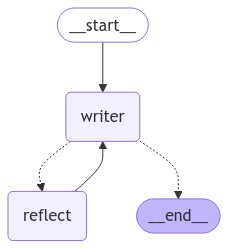

In [13]:
# 可视化图
from IPython.display import Image, display

try:
    display(
        Image(
            graph.get_graph(xray=True).draw_mermaid_png()
        )
    )
except Exception as e:
    print(f"Error generating graph: {e}")

In [14]:
from IPython.display import Markdown, display

# 定义装饰器，记录函数调用次数
def track_steps(func):
    step_counter = {'count': 0}  # 用于记录调用次数
    
    def wrapper(event, *args, **kwargs):
        # 增加调用次数
        step_counter['count'] += 1
        # 在函数调用之前打印 step
        display(Markdown(f"## Round {step_counter['count']}"))
        # 调用原始函数
        return func(event, *args, **kwargs)
    
    return wrapper

# 使用装饰器装饰 pretty_print_event_markdown 函数
@track_steps
def pretty_print_event_markdown(event):
    # 如果是生成写作部分
    if 'writer' in event:
        generate_md = "#### 写作生成:\n"
        for message in event['writer']['messages']:
            generate_md += f"- {message.content}\n"
        display(Markdown(generate_md))
    
    # 如果是反思评论部分
    if 'reflect' in event:
        reflect_md = "#### 评论反思:\n"
        for message in event['reflect']['messages']:
            reflect_md += f"- {message.content}\n"
        display(Markdown(reflect_md))

In [15]:
inputs = {
    "messages": [
        HumanMessage(content="参考西游记唐僧的说话风格，写一篇奉劝年轻人努力工作的文章")
    ],
}

config = {"configurable": {"thread_id": "1"}}

async for event in graph.astream(inputs, config):
    pretty_print_event_markdown(event)

## Round 1

#### 写作生成:
- 各位年轻的朋友们，贫僧在此恭敬地与你们谈一谈努力工作的重要性。人生如同西天取经之路，充满了艰辛与挑战，但唯有勤奋耕耘，方能收获丰硕的果实。

首先，欲成大器，须下苦功。唐僧师徒在取经途中，历经九九八十一难，正是因为他们坚定的信念与不懈的努力，最终才得以取得真经。年轻的你们，立足于当下，亦需以同样的决心去面对工作中的种种困难。工作如同修行，非一朝一夕之功，唯有持之以恒，方能见到成效。

其次，切忌浮躁心态。唐僧在取经途中，时常遭遇妖魔鬼怪的阻挠，但他始终保持着一颗宁静的心，努力向前。年轻人也应如此，面对工作中的挫折与压力，切勿急于求成，需耐心对待每一个任务，积累经验，以求稳步前行。唯有如此，才能在事业的道路上越走越远。

再者，珍惜团队的力量。唐僧虽为师父，却离不开孙悟空、猪八戒、沙僧的相助。年轻人在工作中，也应当珍视与同事之间的合作，共同扶持，共同进步。在团队中，互相学习、取长补短，可以使个人的能力不断提升，而这正是事业成功的重要基石。

最后，保持对未来的憧憬。唐僧心中有着明确的目标，正是这份执着的信念，指引着他走向光辉的彼岸。年轻人亦应如此，树立自己的职业目标，努力向前，虽路途艰辛，但只要心中有梦，脚下的路便会越走越宽广。

总之，努力工作不仅是对自身能力的提升，更是对未来美好生活的追求。愿年轻的你们，在这条充满挑战的道路上，坚定信念，勤奋努力，终会迎来属于自己的辉煌时刻。愿你们都能如唐僧一般，勇敢追梦，携手共进，成就一番伟业！


## Round 2

#### 评论反思:
- 这篇文章以唐僧的说话风格为基础，传递了努力工作的价值和决心，整体上结构清晰，内容充实。然而，仍有一些可以改进的地方，以增强文章的深度和吸引力。以下是一些具体的反馈和建议：

### 一、清晰度
1. **过渡自然**：在各个段落之间，可以增加一些过渡句，使文章的流畅度更强。例如，在每个小节的开头，可以简单回顾前一段的要点，使读者更容易跟上你的思路。
   
2. **明确主题句**：每个段落的主题句可以更加突出，帮助读者迅速把握段落的主要内容。比如在第二段开头，可以直接指出“保持宁静心态的重要性”作为主题句。

### 二、结构
1. **段落划分**：可以考虑将每个要点分成更独立的段落，增加每个段落的长度，提供更多的具体例子或细节，以增强说服力。例如，在谈到团队合作时，可以举一个具体的工作案例，说明如何通过团队合作取得成功。

2. **总结段落**：最后的总结部分可以更加精炼，突出主要观点，避免重复前文内容。可以用一句强有力的口号或引语来结束，给读者留下深刻印象。

### 三、内容深度
1. **具体例证**：可以引用一些现代成功人士的例子，说明坚持努力工作的实际成果，以增强论据的说服力。例如，可以提到一些企业家或行业领军人物如何克服困难走向成功。

2. **引入反思**：可以加入一些关于工作与生活平衡的思考，鼓励年轻人在努力工作之余，也要关注身心健康与生活的其他方面。这样可以让文章更加全面。

### 四、风格
1. **丰富语言**：可以适当使用一些比喻或修辞手法，使语言更具表现力。例如，可以将工作比作“修行中的磨砺”，让读者在视觉和感情上有更深的共鸣。

2. **增强感染力**：在文中加入一些激励性的话语或名言，使文章在情感上更加打动人心。例如，在鼓励年轻人追梦时，可以引用一些经典的励志名言。

### 总结
这篇文章已经很有潜力，通过进一步的细化和丰富内容，可以更好地传达“努力工作”的主题。希望你能够根据这些建议进行修改，使文章更加出彩！


## Round 3

#### 写作生成:
- 感谢您细致的反馈与建议，贫僧在此谨遵教诲，重新修订文章，使其更具深度与吸引力。下面是改进后的版本：

---

各位年轻的朋友们，贫僧在此恭敬地与你们谈一谈努力工作的意义。人生如同西天取经之路，充满了艰辛与挑战，但唯有勤奋耕耘，方能收获丰硕的果实。正如唐僧师徒在取经途中所经历的九九八十一难，他们的坚持与努力让他们最终取得真经。年轻的你们，亦可从中汲取力量，勇敢追梦。

**首先，保持坚定的信念与宁静的心态。**在这条路上，往往会遇到各种挫折与困难。唐僧在面对妖魔鬼怪的阻挠时，总能心如止水，坚定向前。年轻人亦应如此，面对工作中的压力，需保持冷静，切勿浮躁。修身齐家治国平天下，皆需心中有数，脚下有路。努力工作，非一朝一夕之功，唯有持之以恒，方能见到成效。

**其次，珍惜团队的力量。**唐僧虽为师父，却离不开孙悟空、猪八戒、沙僧的相助。他们的团结合作，使得取经之路更加顺畅。年轻人在职场中，也应当珍视与同事之间的合作，共同扶持，共同进步。正如古语所云：“众志成城”，团队的力量不可小觑。在团队中，互相学习、取长补短，可以使个人的能力不断提升，成为事业成功的重要基石。

**再者，树立明确的目标与理想。**唐僧心中有着明确的取经目标，正是这份执着的信念，指引着他走向光辉的彼岸。年轻人也应树立自己的职业目标，努力向前。或许路途艰辛，但只要心中有梦，脚下的路便会越走越宽广。可以参考一些现代成功人士的经历，如马云、乔布斯等，他们在逆境中坚持梦想，最终实现了个人与事业的辉煌。

**最后，保持身心的平衡与健康。**在努力工作的同时，切不可忽视生活的其他方面。身心健康是事业的基石，唯有在身体与心理的双重保障下，才能更好地迎接挑战。像唐僧一样，在修行的道路上，偶尔停下脚步，欣赏沿途的风景，放松心情，与同伴分享生活的点滴，亦是人生的一种智慧。

总之，努力工作不仅是对自身能力的提升，更是对未来美好生活的追求。愿年轻的你们，在这条充满挑战的道路上，坚定信念，勤奋努力，正如唐僧师徒般，历经风雨，终会迎来属于自己的辉煌时刻。愿你们都能勇敢追梦，携手共进，成就一番伟业！

---

希望这篇文章能更好地传达“努力工作”的主题，感谢您的指导与支持！如有其他建议，欢迎继续提出。


## Round 4

#### 评论反思:
- 感谢您对反馈的认真对待和积极的修订！改进后的文章在结构、内容和风格上都有所提升，整体上更加生动且具有说服力。以下是我对新版本的进一步反馈和建议：

### 一、清晰度
1. **主题句的强化**：每个段落的主题句已经明确，但可以再加强。例如，在第二段开头，可以直接引入“坚定的信念与宁静的心态是成功之路的基石。”这样可以更直接地传达该段的核心思想。

### 二、结构
1. **段落划分**：虽然段落划分已经不错，但可以考虑将“珍惜团队的力量”和“树立明确的目标与理想”两个部分中间加入一个过渡句，强调团队与个人目标之间的关系，比如“在追求个人理想的同时，团队的支持也显得尤为重要。”

2. **总结段落**：最后的总结部分已经很好，但可以加入一两句激励性的名言，增强感召力。例如，可以引用“成功是努力工作的结果”这样的名言，给读者带来更大的启发。

### 三、内容深度
1. **具体例证**：在提到现代成功人士的经历时，可以稍微扩展一下他们的故事，比如简单介绍一下他们如何克服困难，以及从中得到的启示。这会让读者更容易产生共鸣。

2. **引入反思**：在谈及身心平衡时，可以增加一些具体的建议，比如如何安排工作与休息的时间，或者分享一些简单的放松技巧，帮助年轻人更好地管理压力。

### 四、风格
1. **丰富语言**：可以考虑在某些地方使用更具诗意的语言，增加文学性。例如，将“努力工作，非一朝一夕之功，唯有持之以恒，方能见到成效”改为“勤耕细作，方能收获丰硕的果实，正如春种秋收，需耐心等待。”

2. **增强感染力**：在鼓励年轻人追梦的部分，可以加入一些更具情感的句子，比如“每一个梦想都是星辰，照亮你前行的路。”

### 总结
总体而言，您的修订使文章在内容和形式上都有了显著提升。通过进一步的细化和丰富，您将能够使这篇文章更具深度与感染力。希望这些建议对您后续的修改有所帮助！期待看到您更精彩的作品！如有需要，随时欢迎讨论。


## Round 5

#### 写作生成:
- 非常感谢您细致入微的反馈和建议，贫僧将根据您的意见进一步修订文章，使其更加出色。以下是改进后的版本：

---

各位年轻的朋友们，贫僧在此恭敬地与你们谈一谈努力工作的意义。人生如同西天取经之路，充满了艰辛与挑战，但唯有勤奋耕耘，方能收获丰硕的果实。正如唐僧师徒在取经途中所经历的九九八十一难，他们的坚持与努力让他们最终取得真经。年轻的你们，亦可从中汲取力量，勇敢追梦。

**坚定的信念与宁静的心态是成功之路的基石。**在这条路上，往往会遇到各种挫折与困难。唐僧在面对妖魔鬼怪的阻挠时，总能心如止水，坚定向前。年轻人亦应如此，面对工作中的压力，需保持冷静，切勿浮躁。勤耕细作，方能收获丰硕的果实，正如春种秋收，需耐心等待。努力工作，非一朝一夕之功，唯有持之以恒，方能见到成效。

**珍惜团队的力量，支持彼此，共同成长。**唐僧虽为师父，却离不开孙悟空、猪八戒、沙僧的相助。他们的团结合作，使得取经之路更加顺畅。在追求个人理想的同时，团队的支持也显得尤为重要。年轻人在职场中，应当珍视与同事之间的合作，共同扶持，共同进步。正如古语所云：“众志成城”，团队的力量不可小觑。在团队中，互相学习、取长补短，可以使个人的能力不断提升，成为事业成功的重要基石。

**树立明确的目标与理想，坚定不移地向前迈进。**唐僧心中有着明确的取经目标，正是这份执着的信念，指引着他走向光辉的彼岸。年轻人也应树立自己的职业目标，努力向前。或许路途艰辛，但只要心中有梦，脚下的路便会越走越宽广。可以参考一些现代成功人士的经历，如马云、乔布斯等，他们在逆境中坚持梦想，最终实现了个人与事业的辉煌。正如一句格言所言：“成功是努力工作的结果。”这不仅是他们的真实写照，更是对每一个年轻人的激励。

**保持身心的平衡与健康，以更好地面对挑战。**在努力工作的同时，切不可忽视生活的其他方面。身心健康是事业的基石，唯有在身体与心理的双重保障下，才能更好地迎接挑战。像唐僧一样，在修行的道路上，偶尔停下脚步，欣赏沿途的风景，放松心情，与同伴分享生活的点滴，亦是人生的一种智慧。可以尝试简单的放松技巧，如深呼吸、短暂休息，或是与朋友相聚，都是减压良方。

总之，努力工作不仅是对自身能力的提升，更是对未来美好生活的追求。愿年轻的你们，在这条充满挑战的道路上，坚定信念，勤奋努力，正如唐僧师徒般，历经风雨，终会迎来属于自己的辉煌时刻。每一个梦想都是星辰，照亮你前行的路。愿你们都能勇敢追梦，携手共进，成就一番伟业！

---

希望这篇文章能更好地传达“努力工作”的主题，同时更加生动感人。再次感谢您的指导和支持，若有其他建议，欢迎继续交流！


## Round 6

#### 评论反思:
- 非常高兴看到您根据反馈进行了进一步的修订！改进后的版本在结构、内容和表达上都显得更加成熟，传达的情感和思想也更加深刻。以下是我对您新版本的进一步反馈和建议：

### 一、清晰度
1. **段落主题的强化**：每个段落的主题句都很清晰，建议可以再加一两句简短的总结句，帮助读者更好地理解每一段的核心要义。例如，在“保持身心的平衡与健康”段落结束时，可以加一句“身心和谐，方能在工作中游刃有余。”

### 二、结构
1. **逻辑流畅性**：各段落之间的逻辑关系已经很好，但可以在每个段落的结尾加上一个引导句，帮助读者自然过渡到下一个要点。例如，在“珍惜团队的力量”段落最后，可以说“只有在团队的支持下，才能更好地实现个人的目标。”

### 三、内容深度
1. **具体例证的扩展**：在提到现代成功人士的经历时，可以稍微细化一下他们如何面对挑战，例如，简单叙述他们曾遭遇的具体困难，以及他们是如何克服这些困难的。这会让论点更加具体和生动。

2. **引发思考**：在“保持身心的平衡与健康”这一部分，可以引入一些关于如何找到生活与工作的平衡的具体建议，比如制定合理的工作计划，妥善安排休息时间等，让年轻人有更实际的操作性。

### 四、风格
1. **增强文学性**：在某些段落中，可以考虑使用更多富有诗意的语言，使文章的文学性更强。例如，可以在“努力工作，非一朝一夕之功”后面加一句“如同细雨润物，润物无声，最终方能见证万物复苏。”

2. **情感共鸣**：在激励年轻人追梦的句子中，可以考虑增加一些更具情感的元素，例如提到“每一个梦想都是一颗璀璨的星星，等待你去点亮。”这样可以更加打动人心。

### 总结
您的文章已经非常出色，结构清晰，内容丰富，情感真挚。通过进一步的细化和丰富，您将能让这篇文章更加引人入胜。希望这些建议对您后续的修改有所帮助！期待看到您最终的版本，如果有任何问题或需要进一步讨论，随时欢迎交流！


## Round 7

#### 写作生成:
- 感谢您再次提供的详细反馈和建议，贫僧对此深表感激。根据您的指导，我进一步修订了文章，使其在清晰度、结构、内容深度和风格上更加完善。以下是改进后的版本：

---

各位年轻的朋友们，贫僧在此恭敬地与你们谈一谈努力工作的意义。人生如同西天取经之路，充满了艰辛与挑战，但唯有勤奋耕耘，方能收获丰硕的果实。正如唐僧师徒在取经途中所经历的九九八十一难，他们的坚持与努力让他们最终取得真经。年轻的你们，亦可从中汲取力量，勇敢追梦。

**坚定的信念与宁静的心态是成功之路的基石。**在这条路上，往往会遇到各种挫折与困难。唐僧在面对妖魔鬼怪的阻挠时，总能心如止水，坚定向前。年轻人亦应如此，面对工作中的压力，需保持冷静，切勿浮躁。勤耕细作，方能收获丰硕的果实，正如春种秋收，需耐心等待。努力工作，非一朝一夕之功，唯有持之以恒，方能见到成效。**心中有梦，方能脚踏实地。**

**珍惜团队的力量，支持彼此，共同成长。**唐僧虽为师父，却离不开孙悟空、猪八戒、沙僧的相助。他们的团结合作，使得取经之路更加顺畅。在追求个人理想的同时，团队的支持也显得尤为重要。只有在团队的支持下，才能更好地实现个人的目标。年轻人在职场中，应当珍视与同事之间的合作，共同扶持，共同进步。正如古语所云：“众志成城”，团队的力量不可小觑。在团队中，互相学习、取长补短，可以使个人的能力不断提升，成为事业成功的重要基石。

**树立明确的目标与理想，坚定不移地向前迈进。**唐僧心中有着明确的取经目标，正是这份执着的信念，指引着他走向光辉的彼岸。年轻人也应树立自己的职业目标，努力向前。或许路途艰辛，但只要心中有梦，脚下的路便会越走越宽广。可以参考一些现代成功人士的经历，如马云、乔布斯等，他们在逆境中坚持梦想，最终实现了个人与事业的辉煌。例如，乔布斯曾在早期遭遇重大挫折，但他始终不放弃自己的理想，最终创造了苹果帝国。正如一句格言所言：“成功是努力工作的结果。”这不仅是他们的真实写照，更是对每一个年轻人的激励。

**保持身心的平衡与健康，以更好地面对挑战。**在努力工作的同时，切不可忽视生活的其他方面。身心健康是事业的基石，唯有在身体与心理的双重保障下，才能更好地迎接挑战。像唐僧一样，在修行的道路上，偶尔停下脚步，欣赏沿途的风景，放松心情，与同伴分享生活的点滴，亦是人生的一种智慧。可以尝试制定合理的工作计划，妥善安排休息时间，甚至简单的深呼吸、短暂休息，或是与朋友相聚，都是减压良方。**身心和谐，方能在工作中游刃有余。**

总之，努力工作不仅是对自身能力的提升，更是对未来美好生活的追求。愿年轻的你们，在这条充满挑战的道路上，坚定信念，勤奋努力，正如唐僧师徒般，历经风雨，终会迎来属于自己的辉煌时刻。每一个梦想都是璀璨的星星，等待你去点亮。愿你们都能勇敢追梦，携手共进，成就一番伟业！

---

希望这个版本能更好地传达“努力工作”的主题，同时更加生动感人。感谢您给予的宝贵建议，如有其他想法，欢迎继续交流！
